In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inlin


Bad key "text.kerning_factor" on line 4 in
C:\Users\victo\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* CAD/JPY exchange rate returns. 

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Data Preparation

### Returns

In [4]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
cad_jpy_df['Return'] = (cad_jpy_df[["Price"]].pct_change() * 100)
cad_jpy_df = cad_jpy_df.replace(-np.inf, np.nan).dropna()
cad_jpy_df.tail()

,Price,Open,High,Low,Return
Date,,,,,
2020-05-29,78.29,78.21,78.41,77.75,0.076697
2020-06-01,79.27,78.21,79.36,78.04,1.251756
2020-06-02,80.40,79.26,80.56,79.15,1.425508
2020-06-03,80.70,80.40,80.82,79.96,0.373134
2020-06-04,80.71,80.80,80.89,80.51,0.012392


### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
cad_jpy_df['lagged_return'] = cad_jpy_df['Return'].shift()
cad_jpy_df.dropna(inplace=True)
cad_jpy_df

,Price,Open,High,Low,Return,lagged_return
Date,,,,,,
1990-01-04,123.46,123.41,123.46,123.41,-1.468476,-0.846720
1990-01-05,124.54,124.48,124.54,124.48,0.874777,-1.468476
1990-01-08,124.27,124.21,124.27,124.21,-0.216798,0.874777
1990-01-09,125.10,125.04,125.10,125.04,0.667901,-0.216798
1990-01-10,125.81,125.75,125.81,125.75,0.567546,0.667901
1990-01-11,125.85,125.80,125.85,125.80,0.031794,0.567546
1990-01-12,126.00,125.94,126.00,125.94,0.119190,0.031794
1990-01-15,125.22,125.16,125.22,125.16,-0.619048,0.119190
1990-01-16,124.94,124.89,124.94,124.89,-0.223606,-0.619048


### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = cad_jpy_df[:'2017']
test = cad_jpy_df['2018':]

In [15]:
train

,Price,Open,High,Low,Return,lagged_return
Date,,,,,,
1990-01-04,123.46,123.41,123.46,123.41,-1.468476,-0.846720
1990-01-05,124.54,124.48,124.54,124.48,0.874777,-1.468476
1990-01-08,124.27,124.21,124.27,124.21,-0.216798,0.874777
1990-01-09,125.10,125.04,125.10,125.04,0.667901,-0.216798
1990-01-10,125.81,125.75,125.81,125.75,0.567546,0.667901
1990-01-11,125.85,125.80,125.85,125.80,0.031794,0.567546
1990-01-12,126.00,125.94,126.00,125.94,0.119190,0.031794
1990-01-15,125.22,125.16,125.22,125.16,-0.619048,0.119190
1990-01-16,124.94,124.89,124.94,124.89,-0.223606,-0.619048


In [18]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
x_train = train['lagged_return'].to_frame()
y_train = train['Return']
x_test = test['lagged_return'].to_frame()
y_test = test['Return']

In [19]:
# Preview the X_train data
x_train

,lagged_return
Date,
1990-01-04,-0.846720
1990-01-05,-1.468476
1990-01-08,0.874777
1990-01-09,-0.216798
1990-01-10,0.667901
1990-01-11,0.567546
1990-01-12,0.031794
1990-01-15,0.119190
1990-01-16,-0.619048


# Linear Regression Model

In [21]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using  just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

# Make predictions using the Testing Data

**Note:** We want to evaluate the model using data that it has never seen before, in this case: `X_test`.

In [22]:
# Make a prediction of "y" values using just the test dataset
y_predict = model.predict(x_test)

In [26]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
combined_df = y_test.to_frame()
combined_df['Predict_Returns'] = y_predict
combined_df.head()

,Return,Predict_Returns
Date,,
2018-01-01,0.245591,0.005434
2018-01-02,-0.055679,-0.007317
2018-01-03,0.011142,0.000340
2018-01-04,0.601604,-0.001358
2018-01-05,0.919158,-0.016366


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000024B9727F9C8>,
      dtype=object)

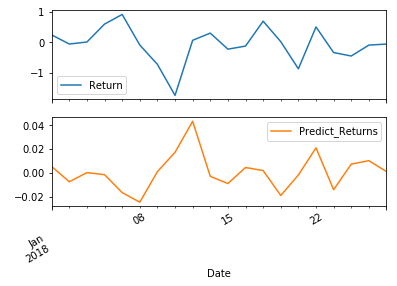

In [30]:
# Plot the first 20 predictions vs the true values
combined_df[:20].plot(subplots = True)

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (`X_test` and `y_test`)

In [34]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# (Hint: use the dataframe from above)
mse = mean_squared_error(combined_df['Return'],combined_df['Predict_Returns'])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")
combined_df

Out-of-Sample Root Mean Squared Error (RMSE): 0.6445805658569028


,Return,Predict_Returns
Date,,
2018-01-01,0.245591,0.005434
2018-01-02,-0.055679,-0.007317
2018-01-03,0.011142,0.000340
2018-01-04,0.601604,-0.001358
2018-01-05,0.919158,-0.016366
2018-01-08,-0.087787,-0.024437
2018-01-09,-0.724876,0.001157
2018-01-10,-1.747981,0.017349
2018-01-11,0.067560,0.043353


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [39]:
# Construct a dataframe using just the "y" training data:
in_sample = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
in_sample['Predictions'] = model.predict(x_train)

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
mse = mean_squared_error(in_sample['Return'],in_sample['Predictions'])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
rmse = np.sqrt(mse)
print(f"in-Sample Root Mean Squared Error (RMSE): {rmse}")


in-Sample Root Mean Squared Error (RMSE): 0.841994632894117


# Conclusions

**Question:** Does this model perform better or worse on out-of-sample data as compared to in-sample data?

**Answer:** It performs better in the out of sample data.